# Identifying cell nuclei in cancer samples

## Explore Data

In [1]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00a 0:00:01


In [2]:
from __future__ import print_function, division
import os
import torch
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
import torchvision.models as models

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

from functools import partial



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

plt.ion()   # interactive mode

In [3]:
data = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv')
data.head()

Filename  Label
0    1.png      0
1    2.png      0
2    3.png      0
3    4.png      0
4    5.png      0

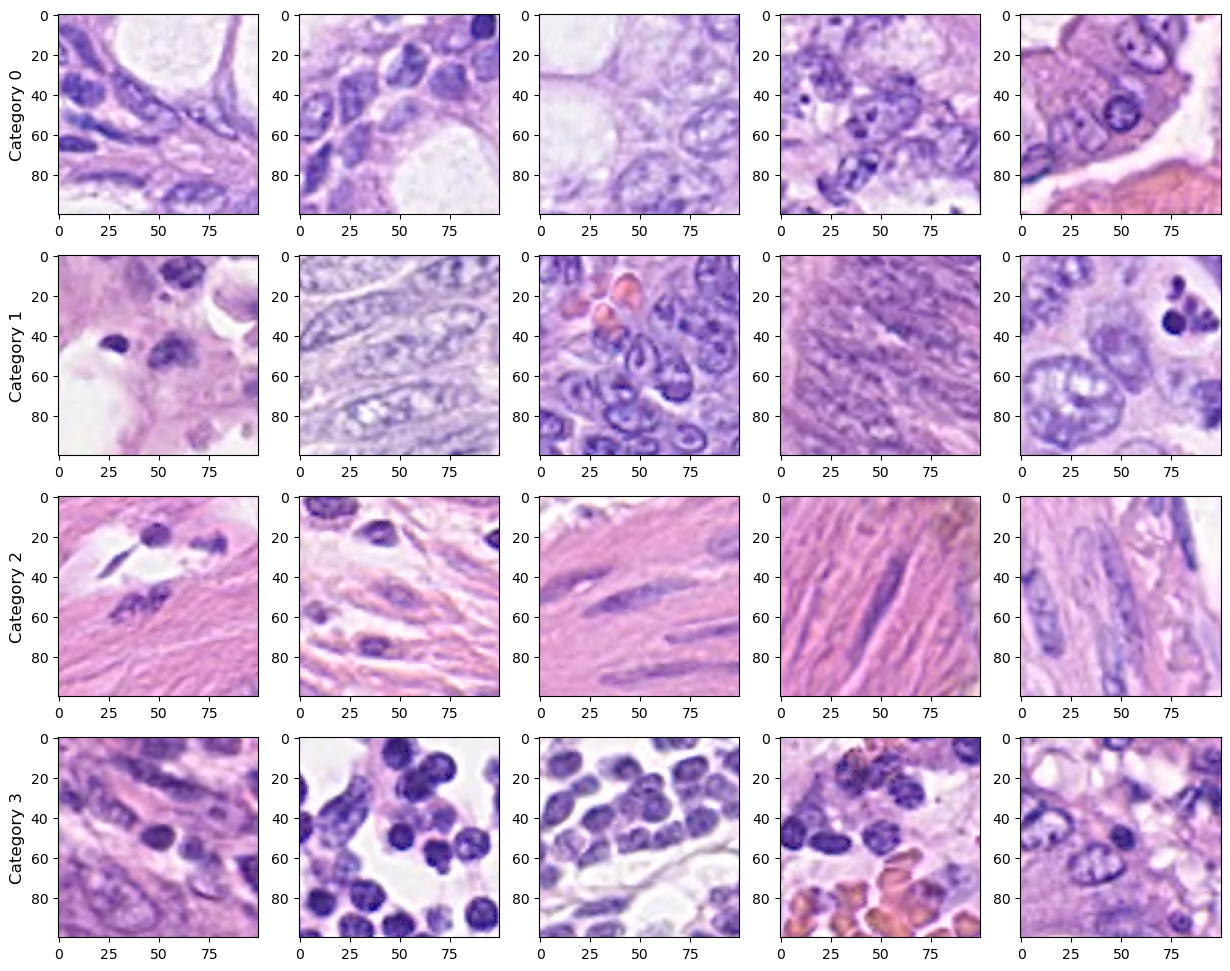

In [4]:
fig, ax = plt.subplots(4,5, figsize=(15,12))
train_path = '/kaggle/input/deep-learning-for-msc-2022-23/train'


for label in range(4):
    for i, idx in enumerate(data[data['Label'] == label]['Filename'][:5]):
        path = os.path.join(train_path, idx)
        ax[label,i].imshow(io.imread(os.path.join(train_path, idx)))
    ax[label,0].set_ylabel('Category ' + str(label), size='large')                    

## Data Preprocessing & Training Preparation

### Write Custom Dataset

In [5]:
class MyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.data.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

### Custom Transform Function

In [6]:
def custom_transform(t_type):
    if t_type == 0:
        return transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) ])
    if t_type == 1:
        return transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     # transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    if t_type == 2:
        return transforms.Compose([
#             transforms.ToPILImage(),
#                                      transforms.Resize(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                  ])
    
    raise ValueError("No such type value")
    
    
TRANS_BASIC = 0
TRANS_RESNET = 1
TRANS_TEST = 2

### My CNN
* Model 1: Custom CNN
* Model 2: Transfer learning model

In [7]:
# Model 1
class MyCNN(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
MODEL_1 = 0
MODEL_2 = 1

In [8]:
class MyResNet(nn.Module):
    def __init__(self):
        super(MyResNet, self).__init__()
        # Model 2
        resnet = models.resnet18(pretrained=True)

#         for param in resnet.parameters():
#             param.requires_grad = False
        
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, 4)
        self.resnet = resnet

    def forward(self, x):
        x = self.resnet(x)
        return x

### Training & Testing Funtion

In [9]:
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Define Ray-tune Function for Tuning Parameters

In [10]:
config_cnn = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-2),
    "batch_size": tune.choice([4, 8, 16, 32])
}

# config_resnet = {
#      "lr": tune.loguniform(1e-4, 1e-2),
#     "momentum": tune.uniform(0.899, 0.999),
#     "weight_decay": tune.loguniform(1e-6, 1e-2),
#     "batch_size": tune.choice([8, 16, 32, 64])
# }

config_resnet = {
     "lr": tune.loguniform(1e-4, 1e-2),
    "amsgrad": tune.choice([True, False]),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "batch_size": tune.choice([8, 16, 32, 64])
}

checkpoint_dir = '/kaggle/working/checkpoint'

In [11]:
def train_net(config, model=0, checkpoint_dir=None, data_dir=None):
    net = None
    optimizer = None
    train_dataset = None
    val_dataset = None
    # Split the data into training and validation sets
    train_data, val_data = train_test_split(pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv'), test_size=0.2, random_state=42)
    
    if model == 0:
        net = MyCNN(config["l1"], config["l2"])
        optimizer = optim.Adam(net.parameters(), lr=config["lr"])
        train_datasset = MyDataset(train_data, train_path, custom_transform(TRANS_BASIC))
        val_dataset = MyDataset(val_data, train_path, custom_transform(TRANS_BASIC))
    else:
        net = MyResNet()
#         optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config['weight_decay'])
        optimizer = optim.Adam(net.parameters(), lr=config["lr"], weight_decay=config['weight_decay'], amsgrad=config['amsgrad'])
        train_datasset = MyDataset(train_data, train_path, custom_transform(TRANS_RESNET))
        val_dataset = MyDataset(val_data, train_path, custom_transform(TRANS_RESNET))
    
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
        
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # Create DataLoader objects for the training and validation sets
    trainloader = DataLoader(train_datasset, batch_size=int(config["batch_size"]), shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=int(config["batch_size"]), shuffle=False)

    
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [12]:
os.environ['RAY_memory_monitor_refresh_ms'] = '0'

def ray_tune(model):
    scheduler = ASHAScheduler(
            metric="loss",
            mode="min",
            max_t=12,
            grace_period=2,
            reduction_factor=2)

    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    
    
    config = config_cnn if model == 0 else config_resnet
    
    result = tune.run(
        partial(train_net, model=model, checkpoint_dir=checkpoint_dir, data_dir='/kaggle/input/deep-learning-for-msc-2022-23/train.csv'),
        resources_per_trial={"cpu": 2, "gpu": 1},
        config=config,
        num_samples=15,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = None
    if model == 0:
        best_trained_model = MyCNN(best_trial.config["l1"], best_trial.config["l2"])
    else:
        best_trained_model = MyResNet()
    
        
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)
    
    if model == 0:
        return best_trained_model, best_trial.config["lr"], best_trial.config["batch_size"]
    else:
        return best_trained_model, best_trial.config["lr"], best_trial.config["batch_size"], best_trial.config["weight_decay"], best_trial.config["amsgrad"]

## Training and Tuning Model

### Model 1: Custom CNN

In [13]:
best_model_1, lr, batch_size = ray_tune(MODEL_1)

2023-03-26 21:04:58,735	INFO worker.py:1535 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:612: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,
E0326 21:05:01.814087521      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 21:05:02 (running for 00:00:00.41)
Memory usage on this node: 1.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_21-05-01
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-----------------------+----------+----------------+--------------+------+------+-------------+
| Trial name            | status   | loc            |   batch_size |   l1 |   l2 |          lr |
|-----------------------+----------+----------------+--------------+------+------+-------------|
| train_net_dfc64_00000 | RUNNING  | 172.19.2.2:317 |            4 |   64 |    4 | 0.0013161   |
| train_net_dfc64_00001 | PENDING  |                |            4 |   32 |   32 | 0.00151101  |
| train_net_dfc64_00002 | PENDING  |                |           16 |  128

== Status ==
Current time: 2023-03-26 21:06:30 (running for 00:01:28.27)
Memory usage on this node: 3.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_21-05-01
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-----------------------+----------+----------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name            | status   | loc            |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+----------+----------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_net_dfc64_00000 | RUNNING  | 172.19.2.2:317 |            4 |   64 |    4 | 0.0013161   | 0.748567 |   0.744048 |      

2023-03-26 21:56:50,780	INFO tune.py:763 -- Total run time: 3109.03 seconds (3108.43 seconds for the tuning loop).


== Status ==
Current time: 2023-03-26 21:56:50 (running for 00:51:48.45)
Memory usage on this node: 3.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -0.520482498415125 | Iter 4.000: -0.42894681249990274 | Iter 2.000: -0.45893533740724834
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_21-05-01
Number of trials: 15/15 (15 TERMINATED)
+-----------------------+------------+-----------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name            | status     | loc             |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_net_dfc64_00000 | TERMINATED | 172.19.2.2:317  |            4 |   64 |    

In [15]:
optimizer = optim.Adam(best_model_1.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

train_data, val_data = train_test_split(pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv'), test_size=0.2, random_state=42)
train_datasset = MyDataset(train_data, train_path, custom_transform(TRANS_BASIC))
val_dataset = MyDataset(val_data, train_path, custom_transform(TRANS_BASIC))
trainloader = DataLoader(train_datasset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [16]:
training_loop(
    n_epochs=24,
    optimizer=optimizer,
    model=best_model_1,
    device=device,
    loss_fn=loss_fn,
    train_loader=trainloader
)

2023-03-26 21:59:32.449796 Epoch 1, Training loss 62.992155955173075
2023-03-26 21:59:58.481904 Epoch 2, Training loss 57.57435409352183
2023-03-26 22:00:25.027555 Epoch 3, Training loss 50.958618496079
2023-03-26 22:00:51.947218 Epoch 4, Training loss 42.95283452910371
2023-03-26 22:01:17.902436 Epoch 5, Training loss 39.077061001677066
2023-03-26 22:01:44.402712 Epoch 6, Training loss 33.09793693223037
2023-03-26 22:02:11.328263 Epoch 7, Training loss 27.312757696025074
2023-03-26 22:02:37.861589 Epoch 8, Training loss 25.211675102589652
2023-03-26 22:03:03.903405 Epoch 9, Training loss 23.693467148812488
2023-03-26 22:03:30.632472 Epoch 10, Training loss 16.435957698966376
2023-03-26 22:03:56.926241 Epoch 11, Training loss 14.566191152320243
2023-03-26 22:04:23.430333 Epoch 12, Training loss 11.355491006514058
2023-03-26 22:04:50.134656 Epoch 13, Training loss 15.317626801668666
2023-03-26 22:05:17.438143 Epoch 14, Training loss 9.732225598971127
2023-03-26 22:05:44.709913 Epoch 15,

In [17]:
test_loop(best_model_1, device, valloader)


Test set: Average loss: 0.7576, Accuracy: 1286/1512 (85%)



### Model 2: Custom Resnet18

In [18]:
best_model_2, lr, batch_size, weight_decay, amsgrad = ray_tune(MODEL_2)

== Status ==
Current time: 2023-03-26 22:08:51 (running for 00:00:00.26)
Memory usage on this node: 3.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+-----------+--------------+-------------+----------------+
| Trial name            | status   | loc             | amsgrad   |   batch_size |          lr |   weight_decay |
|-----------------------+----------+-----------------+-----------+--------------+-------------+----------------|
| train_net_ca072_00000 | RUNNING  | 172.19.2.2:3991 | False     |           16 | 0.00118147  |    3.67498e-05 |
| train_net_ca072_00001 | PENDING  |                 | False     |            8 | 0.000512896 |    0.00033

(func pid=3991) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=3991)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=3991) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=3991)   warnings.warn(msg)
(func pid=3991) Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
  0%|          | 0.00/44.7M [00:00<?, ?B/s]
 25%|██▍       | 11.2M/44.7M [00:00<00:

== Status ==
Current time: 2023-03-26 22:09:01 (running for 00:00:10.85)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+-----------+--------------+-------------+----------------+
| Trial name            | status   | loc             | amsgrad   |   batch_size |          lr |   weight_decay |
|-----------------------+----------+-----------------+-----------+--------------+-------------+----------------|
| train_net_ca072_00000 | RUNNING  | 172.19.2.2:3991 | False     |           16 | 0.00118147  |    3.67498e-05 |
| train_net_ca072_00001 | PENDING  |                 | False     |            8 | 0.000512896 |    0.00033

== Status ==
Current time: 2023-03-26 22:09:53 (running for 00:01:02.38)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status   | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+----------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_ca072_00000 | RUNNING  | 172.19.2.2:3991 | False     |           1

(func pid=4391) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=4391)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=4391) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=4391)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:16:34 (running for 00:07:43.88)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.2135547138946621 | Iter 4.000: -0.19694197968040641 | Iter 2.000: -0.3044746867528087
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (13 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_

(func pid=4516) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=4516)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=4516) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=4516)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:18:22 (running for 00:09:31.53)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.2135547138946621 | Iter 4.000: -0.19694197968040641 | Iter 2.000: -0.3162677479604432
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (12 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_

(func pid=4643) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=4643)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=4643) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=4643)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:20:10 (running for 00:11:19.74)
Memory usage on this node: 5.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.2135547138946621 | Iter 4.000: -0.19694197968040641 | Iter 2.000: -0.32806080916807767
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (11 PENDING, 1 RUNNING, 3 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net

(func pid=5028) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=5028)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=5028) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=5028)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:27:35 (running for 00:18:44.29)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.1777587041046405 | Iter 4.000: -0.1755256438748339 | Iter 2.000: -0.3162677479604432
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_c

(func pid=5151) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=5151)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=5151) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=5151)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:29:14 (running for 00:20:23.22)
Memory usage on this node: 5.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.1777587041046405 | Iter 4.000: -0.1755256438748339 | Iter 2.000: -0.32806080916807767
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_c

(func pid=5268) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=5268)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=5268) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=5268)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:30:48 (running for 00:21:58.08)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.1777587041046405 | Iter 4.000: -0.1755256438748339 | Iter 2.000: -0.32830343137263623
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_c

(func pid=5658) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=5658)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=5658) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=5658)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:38:15 (running for 00:29:24.18)
Memory usage on this node: 5.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.14196269431461891 | Iter 4.000: -0.1541093080692614 | Iter 2.000: -0.32806080916807767
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (7 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_

(func pid=5774) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=5774)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=5774) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=5774)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:39:52 (running for 00:31:01.83)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.14196269431461891 | Iter 4.000: -0.1541093080692614 | Iter 2.000: -0.32830343137263623
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (6 PENDING, 1 RUNNING, 8 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_

(func pid=6170) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=6170)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=6170) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=6170)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:47:18 (running for 00:38:27.95)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.12267658372487253 | Iter 4.000: -0.12495991965988651 | Iter 2.000: -0.32806080916807767
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (5 PENDING, 1 RUNNING, 9 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net

(func pid=6349) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=6349)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=6349) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=6349)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:50:25 (running for 00:41:34.35)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.12267658372487253 | Iter 4.000: -0.1541093080692614 | Iter 2.000: -0.3162677479604432
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_

(func pid=6475) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=6475)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=6475) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=6475)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:52:13 (running for 00:43:22.93)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.12267658372487253 | Iter 4.000: -0.1541093080692614 | Iter 2.000: -0.32806080916807767
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net

(func pid=6597) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=6597)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=6597) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=6597)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:53:48 (running for 00:44:57.51)
Memory usage on this node: 5.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.12267658372487253 | Iter 4.000: -0.1541093080692614 | Iter 2.000: -0.32830343137263623
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (2 PENDING, 1 RUNNING, 12 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net

(func pid=6722) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=6722)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=6722) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=6722)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:55:36 (running for 00:46:45.18)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.12267658372487253 | Iter 4.000: -0.1541093080692614 | Iter 2.000: -0.3285460535771948
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_

(func pid=6841) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=6841)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=6841) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=6841)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 22:57:14 (running for 00:48:24.04)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -0.12267658372487253 | Iter 4.000: -0.1541093080692614 | Iter 2.000: -0.34707988116997046
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (1 RUNNING, 14 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_ca072_000

2023-03-26 23:03:07,576	INFO tune.py:763 -- Total run time: 3256.72 seconds (3256.56 seconds for the tuning loop).


== Status ==
Current time: 2023-03-26 23:03:07 (running for 00:54:16.58)
Memory usage on this node: 5.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 8.000: -0.14196269431461891 | Iter 4.000: -0.1400521164954019 | Iter 2.000: -0.3285460535771948
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.27 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_net_2023-03-26_22-08-50
Number of trials: 15/15 (15 TERMINATED)
+-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------+
| Trial name            | status     | loc             | amsgrad   |   batch_size |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|-----------------------+------------+-----------------+-----------+--------------+-------------+----------------+----------+------------+----------------------|
| train_net_ca072_00000 | TERMINATED 

In [19]:
# best_model_2 = MyResNet()
# optimizer = optim.Adam(best_model_2.parameters(), lr=0.00014179646317108378, weight_decay=3.1619982182665846e-6, amsgrad=True)
optimizer = optim.Adam(best_model_2.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad)

# optimizer = optim.SGD(best_model_2.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# optimizer = optim.SGD(best_model_2.parameters(), lr=0.0010461935469505063, momentum=0.9302501361548164, weight_decay=2.296350622413078e-06, nesterov=False)
loss_fn = nn.CrossEntropyLoss()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

train_data, val_data = train_test_split(pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv'), test_size=0.2, random_state=42)
train_datasset = MyDataset(train_data, train_path, custom_transform(TRANS_RESNET))
val_dataset = MyDataset(val_data, train_path, custom_transform(TRANS_RESNET))
trainloader = DataLoader(train_datasset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [20]:
training_loop(
    n_epochs=18,
    optimizer=optimizer,
    model=best_model_2,
    device=device,
    loss_fn=loss_fn,
    train_loader=trainloader
)

2023-03-26 23:04:07.087724 Epoch 1, Training loss 3.0065474102739245
2023-03-26 23:04:42.283935 Epoch 2, Training loss 3.9668581233127043
2023-03-26 23:05:17.373983 Epoch 3, Training loss 2.003592983004637
2023-03-26 23:05:52.025098 Epoch 4, Training loss 1.3818845285568386
2023-03-26 23:06:26.945341 Epoch 5, Training loss 1.5135884072515182
2023-03-26 23:07:01.730572 Epoch 6, Training loss 3.818381765158847
2023-03-26 23:07:36.303139 Epoch 7, Training loss 2.1751158091356046
2023-03-26 23:08:10.949471 Epoch 8, Training loss 2.1730081497807987
2023-03-26 23:08:45.657708 Epoch 9, Training loss 3.3317703986540437
2023-03-26 23:09:20.769208 Epoch 10, Training loss 1.215080201101955
2023-03-26 23:09:55.733670 Epoch 11, Training loss 0.5626160260871984
2023-03-26 23:10:30.531951 Epoch 12, Training loss 0.8361115911975503
2023-03-26 23:11:05.304994 Epoch 13, Training loss 3.6836188751040027
2023-03-26 23:11:40.100344 Epoch 14, Training loss 4.624057229608297
2023-03-26 23:12:14.937899 Epoch 

In [22]:
test_loop(best_model_2, device, valloader)


Test set: Average loss: 0.1182, Accuracy: 1465/1512 (97%)



## Visulization

### Gradient-based attribution

In [25]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz


integrated_gradients = IntegratedGradients(best_model_2)
inputs, targets = next(iter(trainloader))

attributions_ig = integrated_gradients.attribute(inputs[0:1].to(device), target=targets[0:1], n_steps=200)

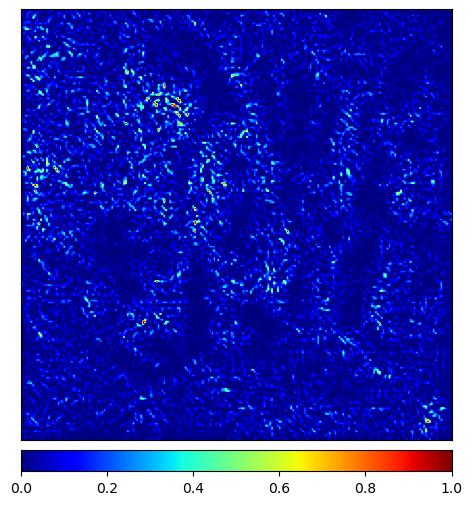

In [46]:
from matplotlib.colors import LinearSegmentedColormap

# default_cmap = LinearSegmentedColormap.from_list('custom blue', 
#                                                  [(0, 'white'),
#                                                   (0.25, 'grey'),
#                                                   (1, 'red')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(inputs[0:1].to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap='jet',
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

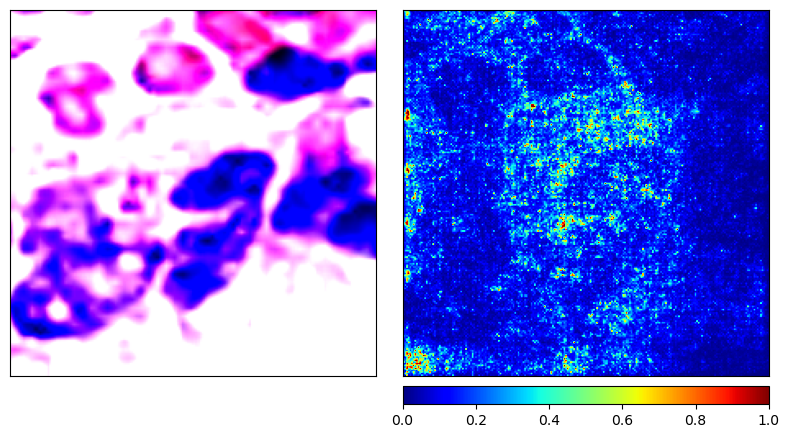

In [47]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(inputs[0:1].to(device), nt_samples=10, nt_type='smoothgrad_sq', target=targets[0:1])
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs[0:1].to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap='jet',
                                      show_colorbar=True)

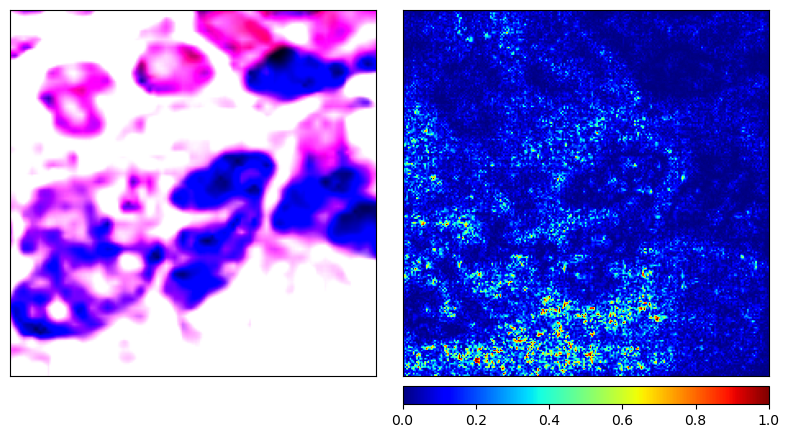

In [48]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(best_model_2)

# Defining baseline distribution of images
rand_img_dist = torch.cat([inputs[0:1] * 0, inputs[0:1] * 1]).to(device)

attributions_gs = gradient_shap.attribute(inputs[0:1].to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=targets[0:1])
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs[0:1].to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap='jet',
                                      show_colorbar=True)

### Occlusion-based attribution

In [41]:
occlusion = Occlusion(best_model_2)

attributions_occ = occlusion.attribute(inputs[0:1].to(device),
                                       strides = (3, 8, 8),
                                       target=targets[0:1],
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

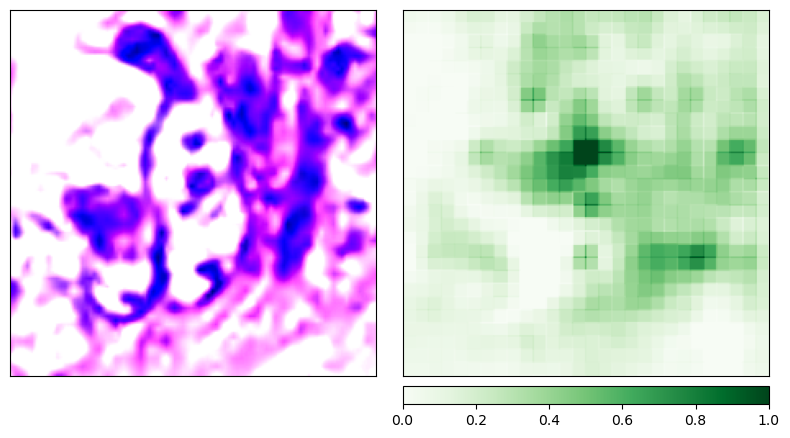

In [42]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs[0:1].to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

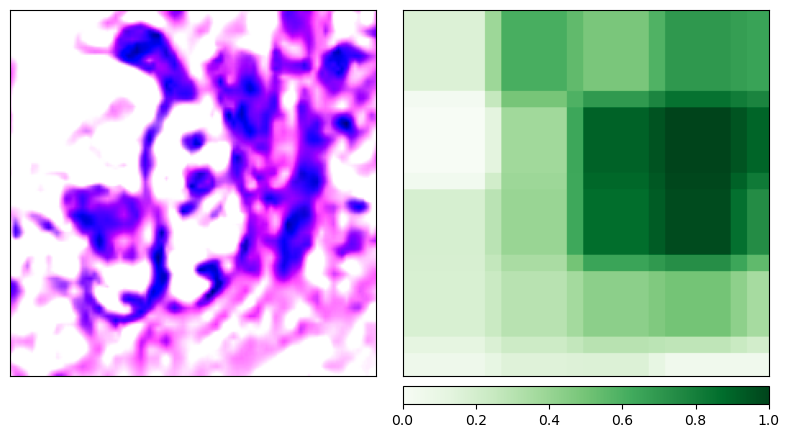

In [44]:
occlusion = Occlusion(best_model_2)

attributions_occ = occlusion.attribute(inputs[0:1].to(device),
                                       strides = (3, 50, 50),
                                       target=targets[0:1],
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs[0:1].to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## Run on Test Data

In [45]:
test_folder = '/kaggle/input/deep-learning-for-msc-2022-23/test'

predictions = list()

image_filenames = [filename for filename in os.listdir(test_folder)]
image_filenames.sort(key=lambda x: int(x.split('.')[0]))

with torch.no_grad():  # to avoid storing gradients
    for filename in image_filenames:
        image = io.imread(test_folder + '/' + filename)
        inputs = custom_transform(TRANS_RESNET)(image)
        inputs = inputs.unsqueeze(0)
        best_model_2.to(device)
        outputs = best_model_2(inputs.to(device))
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.cpu()[0])
    
output = pd.DataFrame({'Filename': image_filenames, 'Label': np.array(predictions)})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
